<a href="https://www.kaggle.com/code/hatemalamir/entailment-bert?scriptVersionId=157977118" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
USE_TPU = False
if USE_TPU:
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
    !pip install torch==2.1.0
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp

!pip install scipy numpy
!pip install transformers datasets==2.15.0
import time
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW


from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

  Obtaining dependency information for datasets==2.15.0 from https://files.pythonhosted.org/packages/e2/cf/db41e572d7ed958e8679018f8190438ef700aeb501b62da9e1eed9e4d69a/datasets-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub>=0.18.0 from https://files.pythonhosted.org/packages/3d/0a/aed3253a9ce63d9c90829b1d36bc44ad966499ff4f5827309099c8c9184b/huggingface_hub-0.20.2-py3-none-any.whl.metadata
INFO: pip is looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tokenizers<0.15,>=0.14 from https://files.pythonhosted.org/packages/57/bd/45b5ef6b088880779f70acf60027f7043ca5fa1b98f4a4345cf3aea09044/tokenizers-0.14.0-cp310-cp310-many

In [2]:
TRAIN_PATH = '//kaggle/input/contradictory-my-dear-watson-train-upsampled/train_upsampled.csv'
TEST_PATH = '//kaggle/input/contradictory-my-dear-watson/test.csv'
OUTPUT_PREFIX = '/kaggle/working/'
MODEL_CKPT = 'Tverous/entailment-classification'
BATCH_SIZE = 2
EPOCHS = 2

In [3]:
input_ds = load_dataset('csv', data_files=TRAIN_PATH)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


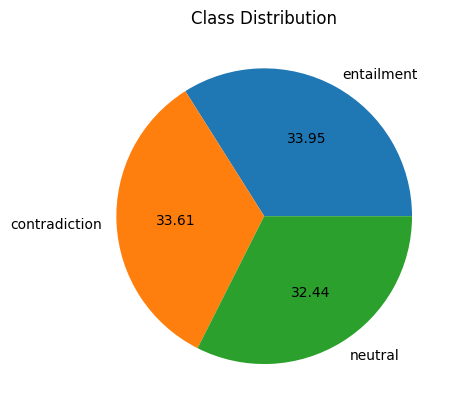

In [4]:
pd.Series(input_ds['train']['label']).map({0: 'entailment', 1:'neutral', 2:'contradiction'}).value_counts().plot.pie(title='Class Distribution', autopct='%.2f', ylabel='');

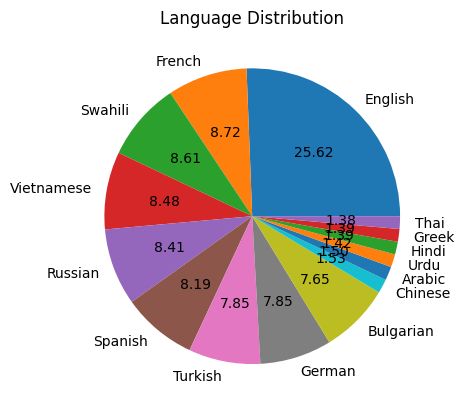

In [5]:
pd.Series(input_ds['train']['language']).value_counts().plot.pie(title='Language Distribution', autopct='%.2f', ylabel='');

In [6]:
if USE_TPU:
    xm.master_print
    device = xm.xla_device()
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'>> Acquired device: {device}')

clf_tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)
print(f'>> Classifier Vocabulary Size: {clf_tokenizer.vocab_size}')
print(f'>> Classifier Model Max Length: {clf_tokenizer.model_max_length}')
clf_model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=3).to(device)
print(f'>> Classifier model footpring: {round(clf_model.get_memory_footprint() / (1024 * 1024), 2)} MB')

def tokenize(examples):
    return clf_tokenizer(
        [p.replace('.', '').strip() + '.' + h.replace('.', ' ').strip() for p, h in zip(examples['premise'], examples['hypothesis'])],
        padding='max_length',
        truncation=True
    )
input_ds = input_ds.map(tokenize, batched=True).shuffle(seed=322)

>> Acquired device: cuda


tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

>> Classifier Vocabulary Size: 128000
>> Classifier Model Max Length: 512


config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

>> Classifier model footpring: 703.53 MB


Map:   0%|          | 0/26820 [00:00<?, ? examples/s]

In [7]:
input_ds = input_ds.remove_columns(['id', 'premise', 'hypothesis', 'language', 'lang_abv'])
input_ds = input_ds.rename_column('label', 'labels')

cutoff_idx = int(input_ds['train'].num_rows * 0.8)
train_ds = input_ds['train'].select(range(0, cutoff_idx))
eval_ds = input_ds['train'].select(range(cutoff_idx, input_ds['train'].num_rows))

train_ds.set_format('torch')
eval_ds.set_format('torch')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
def train_one_epoch(data_loader, model, optimizer, device):
    model.train(True)
    
    running_loss = 0
    last_loss = 0

    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        if USE_TPU:
            xm.mark_step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print(f'>> Batch {i + 1} loss: {last_loss}')
            running_loss = 0
    return last_loss


def eval_one_epoch(data_loader, model, device):
    model.eval()
    
    total_correct = 0
    for i, vbatch in enumerate(data_loader):
        vinputs = {k: v.to(device) for k, v in vbatch.items()}
        with torch.no_grad():
            voutputs = model(**vinputs)
        logits = voutputs.logits
        preds = torch.argmax(logits, axis=-1)
        total_correct += (preds == vbatch['labels'].to(device)).sum()
    accuracy = total_correct / data_loader.dataset.num_rows

    return accuracy.item()

In [9]:
optimizer = AdamW(clf_model.parameters(), lr=5e-5)

# for epoch in range(EPOCHS):
#    print(f'\nEPOCH {epoch + 1}:')
#     st = time.time(); avg_loss = train_one_epoch(train_loader, clf_model, optimizer, device); duration = time.time() - st
#     print(f'>> Avg Loss: {avg_loss}, Duration: {duration}s')
        
#     acc = eval_one_epoch(eval_loader, clf_model, device)
#     print(f'>> Accuracy: {round(100 * acc, 2)}')

In [10]:
test_ds = load_dataset('csv', data_files=TEST_PATH)
test_ds = test_ds.map(tokenize, batched=True)
test_ds.set_format('torch')

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

In [11]:
def predict(batch, model):
    with torch.no_grad():
        return {'prediction': model(torch.tensor(batch['input_ids']).to(device))['logits'].argmax(dim=-1)}
start = time.time(); test_ds = test_ds.map(predict, fn_kwargs={'model': clf_model}, batched=True, batch_size=2); duration = time.time() - start
hours = duration // 3600
rem = duration % 3600
minutes = rem // 60
seconds = rem % 60
print(f'>> Inference took {hours} hours, {minutes} minutes, and {seconds} seconds')

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

/tmp/ipykernel_26/716583366.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'prediction': model(torch.tensor(batch['input_ids']).to(device))['logits'].argmax(dim=-1)}
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/tmp/ipykernel_26/716583366.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'prediction': model(torch.tensor(batch['input_ids']).to(device))['logits'].argmax(dim=-1)}


>> Inference took 0.0 hours, 2.0 minutes, and 46.183046102523804 seconds


In [12]:
test_ds.set_format(type='pandas')
test_df = test_ds['train'][:]
test_df[['id', 'prediction']].to_csv(f'{OUTPUT_PREFIX}submission.csv', index=False)
test_ds.reset_format()